# Преподготовка LFW_faces_dataset -> получение лишь лиц из фото людей

В датасете много папок было с очень малым числом фоток внутри. Удалим такие папки 

In [4]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import cv2

def remove_small_folders(directory, min_files):
    for foldername in os.listdir(directory):
        folder_path = os.path.join(directory, foldername)
        print('folder_path', folder_path)
        if os.path.isdir(folder_path):
            files_in_folder = os.listdir(folder_path)
            if len(files_in_folder) < min_files:
                print(f"Removing folder: {folder_path}")
                shutil.rmtree(folder_path)  # Используйте shutil.rmtree для удаления папки и всего ее содержимого


# Укажите путь к директории с папками и минимальное количество файлов
directory_path = "LFW_faces_dataset"
min_files_count = 4

remove_small_folders(directory_path, min_files_count)

folder_path LFW_faces_dataset/German_Khan
Removing folder: LFW_faces_dataset/German_Khan
folder_path LFW_faces_dataset/Stefano_Gabbana
Removing folder: LFW_faces_dataset/Stefano_Gabbana
folder_path LFW_faces_dataset/Dragan_Covic
Removing folder: LFW_faces_dataset/Dragan_Covic
folder_path LFW_faces_dataset/Jeff_Hornacek
Removing folder: LFW_faces_dataset/Jeff_Hornacek
folder_path LFW_faces_dataset/Sureyya_Ayhan
Removing folder: LFW_faces_dataset/Sureyya_Ayhan
folder_path LFW_faces_dataset/Deb_Santos
Removing folder: LFW_faces_dataset/Deb_Santos
folder_path LFW_faces_dataset/Bob_Newhart
Removing folder: LFW_faces_dataset/Bob_Newhart
folder_path LFW_faces_dataset/Wang_Hailan
Removing folder: LFW_faces_dataset/Wang_Hailan
folder_path LFW_faces_dataset/Paul_McNulty
Removing folder: LFW_faces_dataset/Paul_McNulty
folder_path LFW_faces_dataset/Jimmy_Iovine
Removing folder: LFW_faces_dataset/Jimmy_Iovine
folder_path LFW_faces_dataset/Claudia_Pechstein
folder_path LFW_faces_dataset/Ranil_Wickre

---

Вот как мы лицо можем вытянуть из входной фотографии

In [24]:
import inspect
inspect.getsource(DeepFace.extract_faces)

'def extract_faces(\n    img_path: Union[str, np.ndarray],\n    detector_backend: str = "opencv",\n    enforce_detection: bool = True,\n    align: bool = True,\n    expand_percentage: int = 0,\n    grayscale: bool = False,\n    anti_spoofing: bool = False,\n) -> List[Dict[str, Any]]:\n    """\n    Extract faces from a given image\n\n    Args:\n        img_path (str or np.ndarray): Path to the first image. Accepts exact image path\n            as a string, numpy array (BGR), or base64 encoded images.\n\n        detector_backend (string): face detector backend. Options: \'opencv\', \'retinaface\',\n            \'mtcnn\', \'ssd\', \'dlib\', \'mediapipe\', \'yolov8\', \'centerface\' or \'skip\'\n            (default is opencv).\n\n        enforce_detection (boolean): If no face is detected in an image, raise an exception.\n            Set to False to avoid the exception for low-resolution images (default is True).\n\n        align (bool): Flag to enable face alignment (default is True).\n\

<class 'numpy.ndarray'>
(250, 250, 3)


(134, 98, 3)

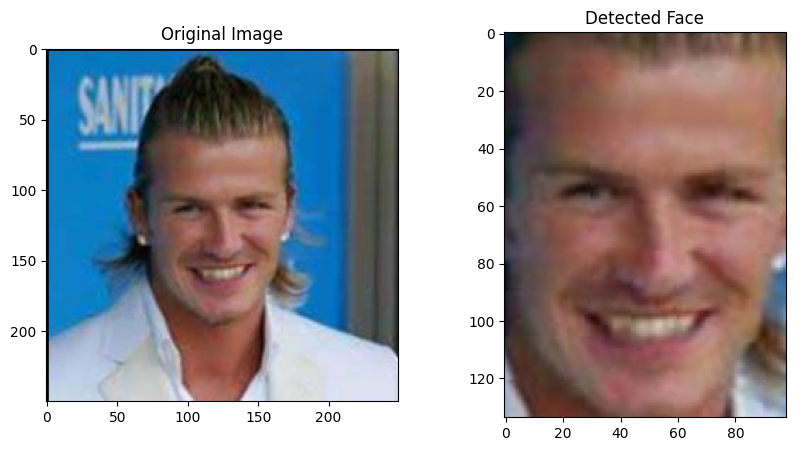

In [22]:
from deepface import DeepFace
import cv2
from  matplotlib import pyplot as plt
from PIL import Image

path = 'LFW_faces_dataset/David_Beckham/David_Beckham_0008.jpg'
face_objs = DeepFace.extract_faces(img_path = path, 
        # target_size = (224, 224), 
        detector_backend = 'yolov8'
    )
face_image = face_objs[0]['face']  # Extract the face image
print(type(face_image))

# Создание subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Отображение исходного изображения
origin_image = plt.imread(path)
axs[0].imshow(origin_image)
axs[0].set_title('Original Image')
print(origin_image.shape)

# Отображение лица
axs[1].imshow(face_image)
axs[1].set_title('Detected Face')
face_image.shape

# print(Image.fromarray(face_image))
# # im.show()
face_image.shape


Заранее удалим все фотки где не получается сделать детекцию или находится более одного лица:

In [ ]:
def remove_invalid_images(directory, min_faces=1, max_faces=1):
    for foldername in tqdm(os.listdir(directory)):
        folder_path = os.path.join(directory, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_path = os.path.join(folder_path, filename)
                    try:
                        # Попытка обнаружения лиц на изображении
                        face_objs = DeepFace.extract_faces(img_path=image_path, detector_backend='yolov8')
                        # Проверка количества обнаруженных лиц
                        print(image_path)
                        if len(face_objs) < min_faces or len(face_objs) > max_faces:
                            print(f"Removing image: {image_path}")
                            os.remove(image_path)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        os.remove(image_path)

# Укажите путь к директории с папками
directory_path = 'LFW_faces_dataset'

# Установите минимальное и максимальное количество лиц на изображении
min_faces_count = 1
max_faces_count = 100

remove_invalid_images(directory_path, min_faces_count, max_faces_count)

Сохраним предобработанный датасет (только кропы лиц):

In [ ]:
def crop_and_save_faces(src_directory, dest_directory, min_faces=1, max_faces=1):
    # Создаем директорию, если ее еще нет
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)

    for foldername in tqdm(os.listdir(src_directory), desc="Processing folders"):
        src_folder_path = os.path.join(src_directory, foldername)
        dest_folder_path = os.path.join(dest_directory, foldername)

        if os.path.isdir(src_folder_path):
            # Создаем папку в новом месте, если ее еще нет
            if not os.path.exists(dest_folder_path):
                os.makedirs(dest_folder_path)

            for filename in tqdm(os.listdir(src_folder_path), desc=f"Processing images in {foldername}"):
                if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    src_image_path = os.path.join(src_folder_path, filename)
                    dest_image_path = os.path.join(dest_folder_path, filename)

                    try:
                        # Попытка обнаружения лиц на изображении
                        face_objs = DeepFace.extract_faces(img_path=src_image_path, detector_backend='yolov8')
                        # Проверка количества обнаруженных лиц
                        if min_faces <= len(face_objs) <= max_faces:
                            # Сохраняем лицо в новую директорию
                            face_image = face_objs[0]['face']
                            rgb_face_image = (face_image * 255).astype(np.uint8)
                            bgr_face_image = cv2.cvtColor(rgb_face_image, cv2.COLOR_RGB2BGR)
                            cv2.imwrite(dest_image_path, bgr_face_image)
                        
                    except Exception as e:
                        print(f"Error processing image {src_image_path}: {e}")


# Путь к исходному и новому датасетам
src_directory_path = 'LFW_faces_dataset'
dest_directory_path = 'LFW_faces_dataset_cropped'

# Установите минимальное и максимальное количество лиц на изображении
min_faces_count = 3
max_faces_count = 100

crop_and_save_faces(src_directory_path, dest_directory_path, min_faces_count, max_faces_count)

In [41]:
for foldername in tqdm(os.listdir(dest_directory_path), desc="Processing folders"):
        dest_folder_path = os.path.join(dest_directory_path, foldername)
        dirs = os.listdir(dest_folder_path)

        if len(dirs) == 1:
                os.remove(os.path.join(dest_folder_path,dirs[0]))
                os.rmdir(dest_folder_path)
                print("Remove: ", dest_folder_path)


Processing folders: 100%|██████████| 56/56 [00:00<00:00, 20771.23it/s]
